Each section can be run seperately.

Credits: Henrique Ennes (https://hlovisiennes.github.io/) and Clément Maria (https://www-sop.inria.fr/members/Clement.Maria/)

# 1. Tests SLP

This section only tests the SLP part of FHD and, therefore, is of a lesser interest to the paper associated to this code. Indeed, some of the functions and modules implemented for SLP (e.g., binary transformation and uncompression), are not needed for the experiments involving the computation of the first homology group of 3-manifolds in the next section, but were implemented for the user's convinience. 

In [1]:
from FHDpy.SLP import SLP

In [2]:
t = SLP(['a'])
s = t.inverse()
t.list_form

['a']

In [2]:
'''
Genrate SLPs
'''
import random 

def generate_exponential(size, dummy = True):
    '''
    Generates a compressed SLP of exponential lenght on its size, given by the number of assignments of form
    
    ['x',#0.#0, #1.#1,...,#n-1.c.#n-1]
    
    where c is either 'y' or '', depending on the parameter dummy.
    
    Parameters
    ----------
    size : int
    Measures the number of assignments of this SLP. Note that len(SLP) >= 2**(size-1).
    dummy : bool
    If True, c = 'y', otherwise c = ''.
    
    Returns
    -------
    slp : SLP
    Compressed SLP for 'x.x.x....x.c.x.x....x', where each string of 'x' has length 2**size.
    sequence : str
    Final sequence 'x.x.x....x.c.x.x....x'. 
    '''
    slp = ['x' if i == 0 else '#' + str(i-1) + '.#' + str(i-1) for i in range(size-1)]
    slp.append('#' + str(size - 2) + '.y.#' + str(size -2)) if dummy else '#' + str(size - 2) + '.#' + str(size -2)
    
    sequence =  int(2**(size - 2))*'x.' +  'y.' + int(2**(size - 2))*'x.' if dummy else int(2**(size - 1))*'x.' 
    sequence = sequence[:-1]
    
    return SLP(slp), sequence

def generate_signed_exponential(size, dummy = True):
    '''
    Generates a compressed SLP of exponential lenght on its size, given by the number of assignments of form
    
    ['x',#0.#0, #1.#1,...,#n-1.c.#n-1*]
    
    where c is either 'y' or '', depending on the parameter dummy.
    
    Parameters
    ----------
    size : int
    Measures the number of assignments of this SLP. Note that len(SLP) >= 2**(size-1).
    dummy : bool
    If True, c = 'y', otherwise c = ''.
    
    Returns
    -------
    slp : SLP
    Compressed SLP for 'x.x.x....x.c.x*.x*....x*', where each string of 'x' has length 2**size.
    sequence : str
    Final sequence 'x.x.x....x.c.x*.x*....x*'. 
    '''
    
    slp = ['x' if i == 0 else '#' + str(i-1) + '.#' + str(i-1) for i in range(size-1)]
    slp.append('#' + str(size - 2) + '.y.#' + str(size -2) +'*') if dummy else '#' + str(size - 2) + '.#' + str(size -2) +'*'
    
    sequence =  int(2**(size - 2))*'x.' +  'y.' + int(2**(size - 2))*'x*.' if dummy else int(2**(size - 2))*'x.' + int(2**(size - 2))*'x*.'
    sequence = sequence[:-1]
    
    return SLP(slp), sequence

def generate_random_slp(size, alphabet = ['x'], signed = True):
    '''
    Generates a random (almost) binary SLP over some alphabet.
    
    Parameters
    ----------
    size : int
    Number os assignments of the generated SLP.
    alphabet : list
    List of simple symbols (strings) used to generate the SLP. Symbols will be necessarily added to the SLP.
    signed : bool Parameters
    If True, it adds some random signs assingnments (but the SLP is not really binary anymore).
    
    Returns
    -------
    slp : SLP
    Random SLP, whose first len(alphabet) assignments are simple symbols and the rest are proper assignments.    
    '''
    slp = [symbol for symbol in alphabet] # Include the alphabet as part of the SLP.
    assignments = ['#' + str(i) for i in range(len(alphabet))] # Make list containing assignments for each simple symbol for later reference.
    
    while len(slp) < size:
        if signed: # If signed, we randomly add negatives to proper assignments.
            sign1 = random.choice(['*',''])
            sign2 = random.choice(['*',''])
        else:
            sign1 = ''
            sign2 = ''
        slp.append(random.choice(assignments) + sign1 + '.' + random.choice(assignments) + sign2) # Make two random proper assignment of previous assignments.
        assignments.append('#' + str(len(assignments))) # Update the list of possible assignments.
    
    return SLP(slp)

In [3]:
slp, sequence = generate_exponential(4)
slp.get_uncompressed(inplace = True)
assert slp.list_form[-1] == sequence

slp, sequence = generate_signed_exponential(4)
slp.get_uncompressed(inplace = True)
assert slp.list_form[-1] == sequence

In [4]:
'''
Test of SLP modules
'''

def test_substitute(list_form, replaced = 'x', replacement = 't', verbose = True):
    '''
    Test if subsititute module is working well.
    
    Parameters
    ----------
    list_form : list
    List form of the SLP (list of strings).
    replaced : str
    Value to be replaced.
    replacement : str
    Substitution value.
    verbose : bool
    If True, prints the SLPs.
    
    Returns
    -------
    None    
    '''
    original =  SLP(list_form)
    binary = original.get_binary()
    uncompressed = original.get_uncompressed()
    
    sequence = uncompressed.list_form[-1]
    new_sequence = ''
    
    if type(replacement) == str:
        for symbol_sequence in sequence.split('.'):
            if symbol_sequence == replaced:
                new_sequence += replacement + '.'
            elif symbol_sequence[:-1] == replaced:
                for symbol_replacement in replacement.split('.')[::-1]:
                    new_sequence += symbol_replacement + '*.' if symbol_replacement[-1] != '*' else symbol_replacement[:-1] + '.'
            else:
                new_sequence += symbol_sequence + '.'
    sequence = new_sequence[:-1]
        
    original = original.substitute(replaced, replacement)
    binary = binary.substitute(replaced, replacement)
    uncompressed = uncompressed.substitute(replaced, replacement)
    
    if type(replacement) != str:
        sequence = uncompressed.get_uncompressed().list_form[-1]
    
    if (sequence != original.get_uncompressed().list_form[-1]) or (sequence != binary.get_uncompressed().list_form[-1]) or (sequence != uncompressed.get_uncompressed().list_form[-1]):
        print('Sequence:\n', sequence, '\n')
        print('Original:')
        print(original.get_uncompressed())
        print('\n')
        print('Binary:')
        print(binary.get_uncompressed())
        print('\n')
        print('Uncompressed:')
        print(uncompressed.get_uncompressed())
        raise ValueError('Implementation mistake in substitute!')
    
    if verbose:
        print('Sequence:\n', sequence, '\n')
        print('Original:')
        print(original)
        print('\n')
        print('Binary:')
        print(binary)
        print('\n')
        print('Uncompressed:')
        print(uncompressed.get_uncompressed())
    return None

def test_count(list_form, symbol = None, verbose = True):
    '''
    Test if count module is working well.
    
    Parameters
    ----------
    list_form : list
    List form of the SLP (list of strings).
    symbol : str
    Symbol to be counted.
    verbose : bool
    If True, prints the counted values and the SLPs.
    
    Returns
    -------
    None  
    '''
    original =  SLP(list_form)
    original_length = len(original)
    
    binary =  original.get_binary()
    binary_length = len(binary)
    
    uncompressed = original.get_uncompressed()
    uncompressed_length = len(uncompressed)
    
    if (binary_length != original_length) or (uncompressed_length != original_length):
        raise ValueError('Implementation mistake in length!')
    
    if symbol != None:
        if (binary.count(symbol) != original.count(symbol)) or (uncompressed.count(symbol) != original.count(symbol)):
                    print('Count original: ', original.count(symbol))
                    print('Count binary: ', binary.count(symbol))
                    print('Count uncompressed: ', uncompressed.count(uncompressed))
                    raise ValueError('Implementation mistake in count!')
    
    if verbose:
        print('Original: ')
        print(original)
        print('Lenght: ', len(original))
        print('Complexity: ', original.complexity())
        print('\n')
        print('Binary: ')
        print(binary)
        print('Lenght: ', len(binary))
        print('Complexity: ', binary.complexity())
        print('\n')
        print('Uncompressed: ')
        print(uncompressed)
        print('Lenght: ', len(uncompressed))
        print('Complexity: ', uncompressed.complexity())
        print('\n\n')

    
    return None

def test_signed_count(list_form, symbol = None, verbose = True):
    '''
    Test if signed count module is working well.
    
    Parameters
    ----------
    list_form : list
    List form of the SLP (list of strings).
    symbol : str
    Symbol to be counted.
    verbose : bool
    If True, prints the counted values and the SLPs.
    
    Returns
    -------
    None  
    '''
    original =  SLP(list_form)
    original_length = len(original)
    
    binary =  original.get_binary()
    binary_length = len(binary)
    
    uncompressed = original.get_uncompressed()
    uncompressed_length = len(uncompressed)
    
    if (binary_length != original_length) or (uncompressed_length != original_length):
        raise ValueError('Implementation mistake in length!')
    
    if symbol != None:
        if (binary.signed_count(symbol) != original.signed_count(symbol)) or (uncompressed.signed_count(symbol) != original.signed_count(symbol)):
                    print('Count original: ', original.signed_count(symbol))
                    print('Count binary: ', binary.signed_count(symbol))
                    print('Count uncompressed: ', uncompressed.signed_count(uncompressed))
                    raise ValueError('Implementation mistake in count!')
    
    if verbose:
        print('Original: ')
        print(original)
        print('Lenght: ', len(original))
        print('Complexity: ', original.complexity())
        print('\n')
        print('Binary: ')
        print(binary)
        print('Lenght: ', len(binary))
        print('Complexity: ', binary.complexity())
        print('\n')
        print('Uncompressed: ')
        print(uncompressed)
        print('Lenght: ', len(uncompressed))
        print('Complexity: ', uncompressed.complexity())
        print('\n\n')
    
    return None

def test_conversions(list_form, verbose = True):
    '''
    Test if conversions are working well by comparing uncompressed versions.
    
    Parameters
    ----------
    list_form : list
    List form of the SLP (list of strings).
    verbose : bool
    If True, prints the uncompressed SLPs.
    
    Returns
    -------
    None  
    '''
    original =  SLP(list_form)
    binary =  original.get_binary()
    uncompressed_original = original.get_uncompressed()
    uncompressed_binary = binary.get_uncompressed()
    
    if verbose:
        print('Original: ', uncompressed_original.list_form[-1])
        print('\n')
        print('Binary: ', uncompressed_binary.list_form[-1])
        print('\n\n')
     
    if uncompressed_original.list_form[-1] != uncompressed_binary.list_form[-1]:
        print('Original: ', uncompressed_original.list_form[-1])
        print('Binary: ', uncompressed_binary.list_form[-1])
        raise ValueError('Implementation error!')

In [5]:
for slp in [['x','y', '#0*.y*.#0', '#2.#2*','z.#3.#1'], generate_exponential(12)[0].list_form, generate_signed_exponential(12)[0].list_form, generate_random_slp(4).list_form]:
    verbose = False
    test_substitute(slp, verbose = verbose)
    test_substitute(slp, replacement = 'x.y', verbose = verbose)
    test_substitute(slp, replacement = 'x.x*', verbose = verbose)
    test_substitute(slp, replacement = SLP(['x','x*','#0.#1*']), verbose = verbose)

    test_count(slp, symbol = 'x', verbose = verbose)
    test_signed_count(slp, symbol = 'x.t', verbose = verbose)
    test_conversions(slp, verbose = verbose)

In [6]:
import matplotlib.pyplot as plt
import time

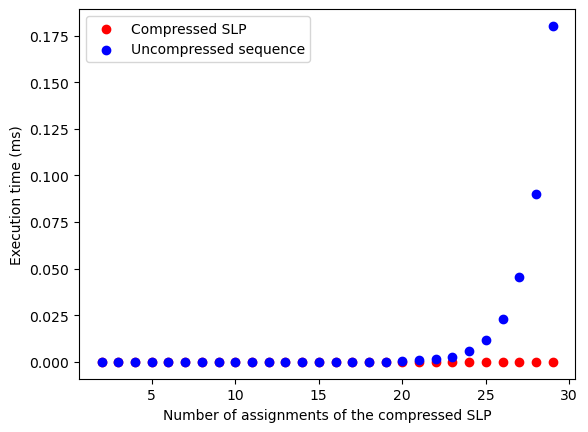

In [7]:
time_slp = []
time_sequence = []
max_complexity = 30
    
for complexity in range(2,max_complexity):
    slp, sequence = generate_exponential(complexity, dummy = False)
    start = time.time()
    slp.count('x')
    end = time.time()
    time_slp.append(end-start)
    
    start = time.time()
    sequence.count('x')
    end = time.time()
    time_sequence.append(end-start)

plt.scatter(range(2,max_complexity), time_slp, c = 'r', label = 'Compressed SLP')
plt.scatter(range(2,max_complexity), time_sequence, c = 'b', label = 'Uncompressed sequence')
plt.legend()
plt.xlabel("Number of assignments of the compressed SLP")
plt.ylabel("Execution time (s)")
plt.show()

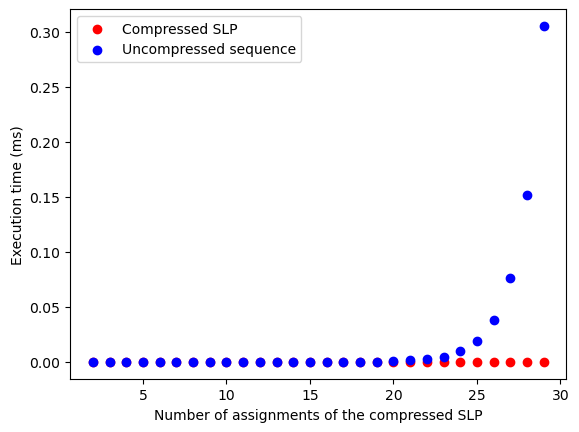

In [8]:
time_slp = []
time_sequence = []
max_complexity = 30
    
for complexity in range(2,max_complexity):
    slp, sequence = generate_signed_exponential(complexity, dummy = False)
    start = time.time()
    slp.signed_count('x*')
    end = time.time()
    time_slp.append(end-start)
    
    start = time.time()
    sequence.count('x*')
    end = time.time()
    time_sequence.append(end-start)

plt.scatter(range(2,max_complexity), time_slp, c = 'r', label = 'Compressed SLP')
plt.scatter(range(2,max_complexity), time_sequence, c = 'b', label = 'Uncompressed sequence')
plt.legend()
plt.xlabel("Number of assignments of the compressed SLP")
plt.ylabel("Execution time (s)")
plt.show()

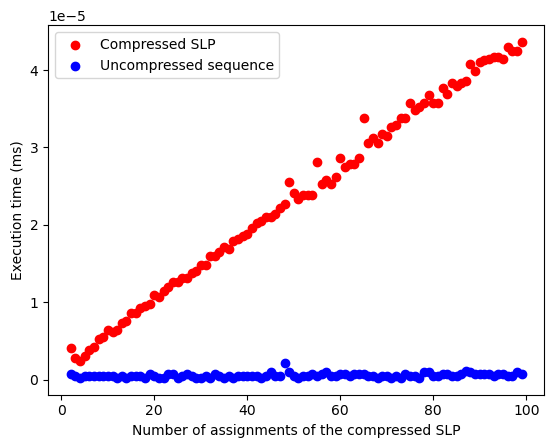

In [9]:
time_slp = []
time_sequence = []
max_complexity = 100
    
for complexity in range(2,max_complexity):
    slp = generate_random_slp(complexity)
    start = time.time()
    slp.count('x')
    end = time.time()
    time_slp.append(end-start)
    
    slp.get_uncompressed(inplace = True)
    start = time.time()
    slp.count('x')
    end = time.time()
    time_sequence.append(end-start)

plt.scatter(range(2,max_complexity), time_slp, c = 'r', label = 'Compressed SLP')
plt.scatter(range(2,max_complexity), time_sequence, c = 'b', label = 'Uncompressed sequence')
plt.legend()
plt.xlabel("Number of assignments of the compressed SLP")
plt.ylabel("Execution time (s)")
plt.show()

 # 2. Test Fast Heegaard diagram

In [1]:
import FHDpy.FHD as FHD
from FHDpy.SLP import SLP as SLP

import snappy

import time
import matplotlib.pyplot as plt
import numpy as np

## 2.1 Genus 1

For genus 1, we have a few options besides FHDLong to compute the homology of a Heegaard splitting given a gluing word. This can be done by FHD_genus1 which already has a triangulation of the torus encoded and no arguments are necessary (in particular, provided the algorithm described by Stefankovic, one can compute the normal coordinates of the Heegaard diagram)

In [2]:
genus1 = FHD.FHD_genus1()
gluing = 'bAbaa' # This can be changed by the user to experiment with distinct 3-manifolds.
genus1.dehn_twist(gluing)
print('Beta curve: ', genus1.get_uncompressed().list_form[-1])
print('Homology: ', genus1.homology())

Beta curve:  b*.b.c.b.c.a.c.c*.b*.b.c.b.c.a.c.b.c.b.c.a.c.c*
Homology:  Z/3


and we can also use the canonical representation of $\text{Mod}(T^2)$ in $\text{GL}(\mathbb{R}^ 2)$ to compute the homology as $\mathbb{Z}/n$ where $n$ is the second coordinate of the vector we act upon.

In [3]:
print('Homology: ', FHD.modular_representation(gluing))

Homology:  Z/3


Of course, this can aslo be done using snappy's twister (with or without an optimization step in which tetrahedra are greedly folded to decrease the size of the triangulation) or using FHDLong

In [4]:
torus = snappy.twister.Surface('S_1')
manifold_optimized = torus.splitting(gluing= gluing, handles= 'a*A')
manifold_not_optimized = torus.splitting(gluing= gluing, handles= 'a*A', optimize = False)

# The cell structure defined below is *not* a triangulation of the torus, but only its usual fundamental polygon. Although normal coordinates are defined only for triangulations, for the kind
# of experiments of this notebook, a triangulation is not necessary, which allows us to use standard curves in more general cellular structures. 
alpha_curves_standard = {'a': SLP(['b*'])}
alpha_curves_edges = {'a':['a']}
generators_standard = {'a': SLP(['b']), 'b': SLP(['a*'])}
generators_edge = {'a':['a'], 'b':['b']}

fhd_compressed = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
fhd_compressed.dehn_twist(gluing, compress = True)

fhd_not_compressed = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
fhd_not_compressed.dehn_twist(gluing, compress = False) # Does not optimize the Heegaard word by compressing it to power form.

print('Homology of snappy (optimization on):', manifold_optimized.homology())
print('Homology of snappy (optimization off):', manifold_not_optimized.homology())
print('FHD (compression on):', fhd_compressed.homology())
print('FHD (compression off):', fhd_not_compressed.homology())

Homology of snappy (optimization on): Z/3
Homology of snappy (optimization off): Z/3
FHD (compression on): Z/3
FHD (compression off): Z/3


### 2.1.1 Gluing 'bA'*n

Recall that the gluing $(bA)^n$ yields to 3-manifolds of homology $\mathbb{Z}/f_{2n}$ where $f_i$ is the $i$-th entry of the Fibonacci sequence starting at $0$ (i.e., $\{0,1,1,2,3,\dots\}$. Let us compute some of these homologies by generating the Fibonacci sequence (with dynamic programing with memorization).

In [5]:
def fib(n):
    fib_list = [0,1]
    while len(fib_list) < n:
        fib_list.append(fib_list[-1] + fib_list[-2])
    
    return fib_list
homology_list = fib(1001)[0::2]

We can use that we know exactly the homology of the manifold with gluing $(bA)^n$ to check which of our methods is more robust.

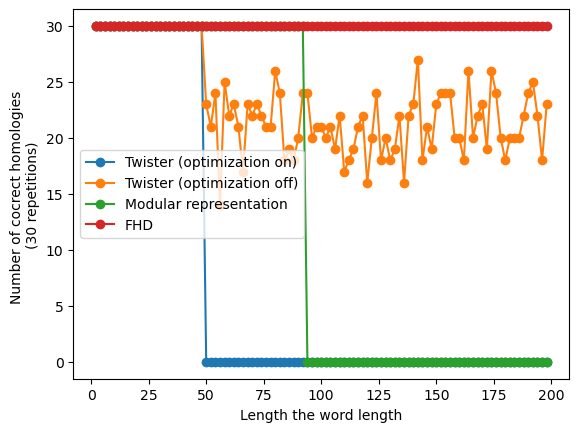

In [6]:
n_rep = 30 # Because of the folding, it there is some randomization in how often snappy + optimization will get the right homology, so we will repeat the experiments n_rep times.
n_max = 100

twister = []
twister_no_optimization = []
modular = []
fhd = []

fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = 'bA'*n
    real_homology = snappy.AbelianGroup([[homology_list[n]]])
    
    counter_us = 0
    counter_twister = 0
    counter_twister_no_optimization = 0
    counter_rep = 0
    
    for rep in range(n_rep):
        manifold_optimized = torus.splitting(gluing = gluing, handles= 'a*A')
        if manifold_optimized.homology() == real_homology: counter_twister += 1
        
        manifold_not_optimized=  torus.splitting(gluing = gluing, handles= 'a*A', optimize = False)
        if manifold_not_optimized.homology() == real_homology: counter_twister_no_optimization += 1
        
        if FHD.modular_representation(gluing) == real_homology: counter_rep += 1
        
        fhd_diagram.reset()
        fhd_diagram.dehn_twist(gluing, compress = False)
        if fhd_diagram.homology() == real_homology: counter_us += 1
        
        
        
    twister.append(np.sum(counter_twister))
    twister_no_optimization.append(np.sum(counter_twister_no_optimization))
    modular.append(np.sum(counter_rep))
    fhd.append(np.sum(counter_us))
    
        
plt.plot(2*np.array(range(1,n_max)), twister, '-o', label = 'Twister (optimization on)')
plt.plot(2*np.array(range(1,n_max)), twister_no_optimization, '-o', label = 'Twister (optimization off)')
plt.plot(2*np.array(range(1,n_max)), modular, '-o', label = 'Modular representation')
plt.plot(2*np.array(range(1,n_max)), fhd, '-o', label = 'FHD')

plt.xlabel('Length the word length')
plt.ylabel('Number of cocrect homologies \n(' + str(n_rep) + ' repetitions)')

plt.legend()
plt.savefig('Images/bA^n.pdf')
plt.show()

Interestingly, we are more numerical stable than numpy for this specific problem.

### 2.1.2 'b'^n

We now explore gluing by $b^n$. This example is interesting because it uses the full power of FHD by compressing the word $b\dot b\dot b\dot\dots\dot b$ into power notation, which can then be executed in only $O(\log(|w|^2))$ instead of $O(|w|^2)$ when the word is not compressed, where $|w|$ is the length of the Heegaard word. We note that, as implemented, the compression takes time $O(|w|)$, so the overall complexity of the problem, even for FHD with optimization on, is only $O(|w|)$.

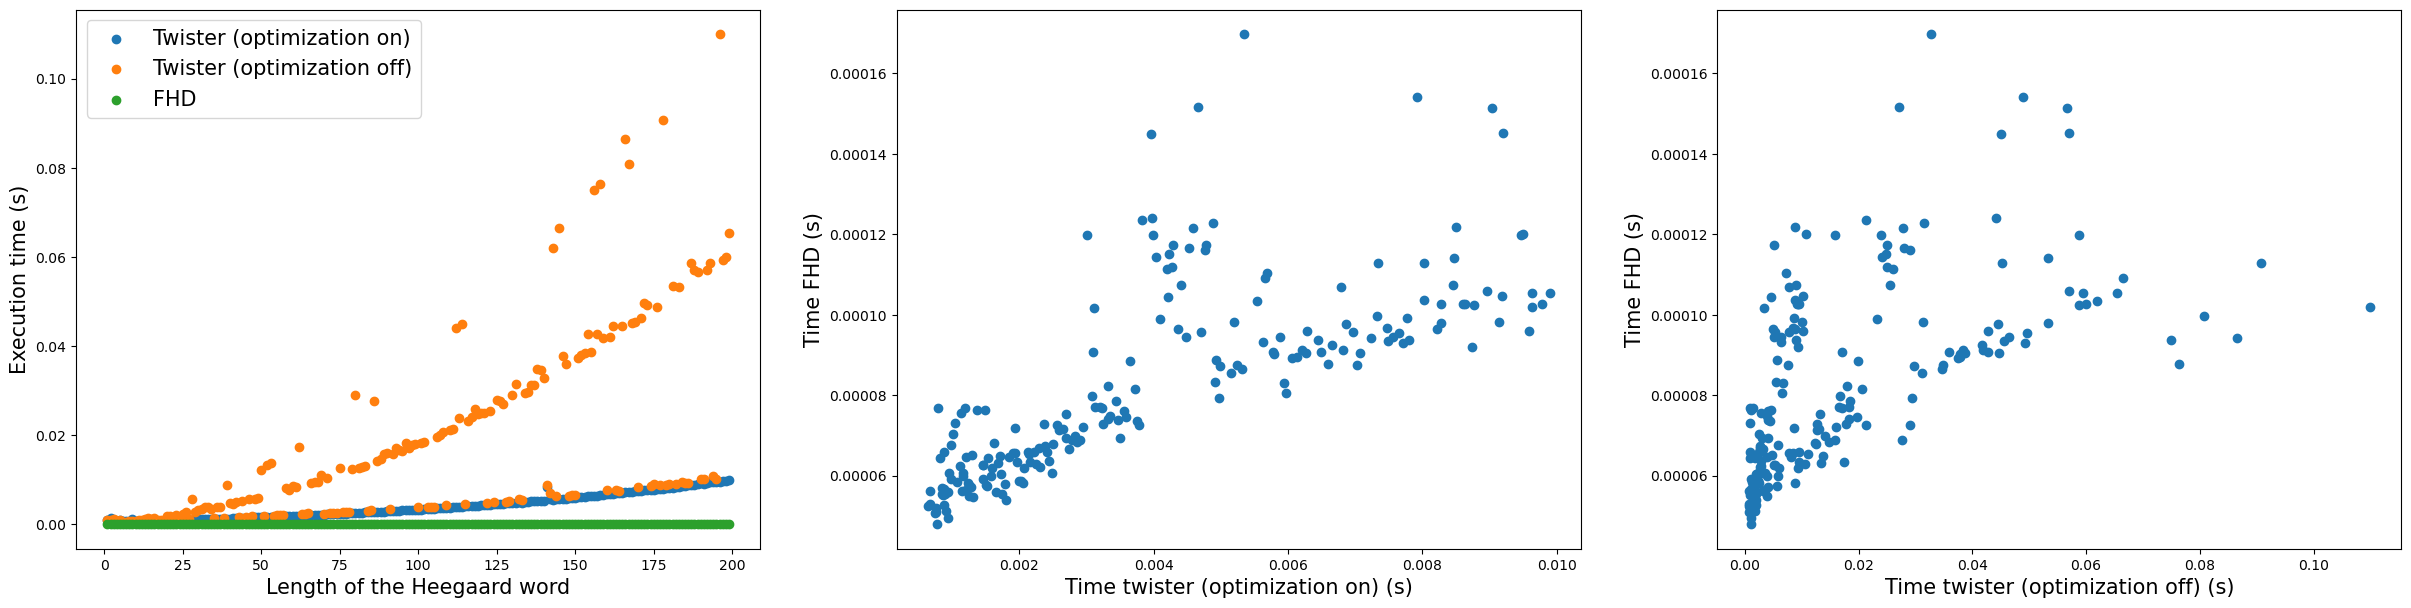

In [7]:
n_max = 200

time_twister = []
time_twister_no_optimization = []
time_fhd = []

fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = 'b'*n
    
    start = time.time()
    manifold_optimized = torus.splitting(gluing = gluing, handles= 'a*A')
    manifold_optimized.homology()
    end = time.time()
    time_twister.append(end-start)

    start = time.time()
    manifold_not_optimized = torus.splitting(gluing = gluing, handles= 'a*A', optimize = False)
    manifold_not_optimized.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)

    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = True)
    fhd_diagram.homology()
    end = time.time()
    time_fhd.append(end-start)    


fig, axs = plt.subplots(1,3, figsize = (30,7))

axs[0].scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
axs[0].scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
axs[0].scatter(range(1,n_max), time_fhd, label = 'FHD')
axs[0].legend(fontsize = 15)
axs[0].set_xlabel('Length of the Heegaard word', fontsize = 15)
axs[0].set_ylabel('Execution time (s)', fontsize = 15)

axs[1].scatter(time_twister, time_fhd)
axs[1].set_xlabel( 'Time twister (optimization on) (s)', fontsize = 15)
axs[1].set_ylabel('Time FHD (s)', fontsize = 15)

axs[2].scatter(time_twister_no_optimization, time_fhd)
axs[2].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[2].set_ylabel('Time FHD (s)', fontsize = 15)

plt.savefig('Images/b^n.pdf')
plt.show()

### 2.1.3 Random

Now we experiment with random words generated by snappy's random_word module. For comparison, we use both FHD with and without compression.

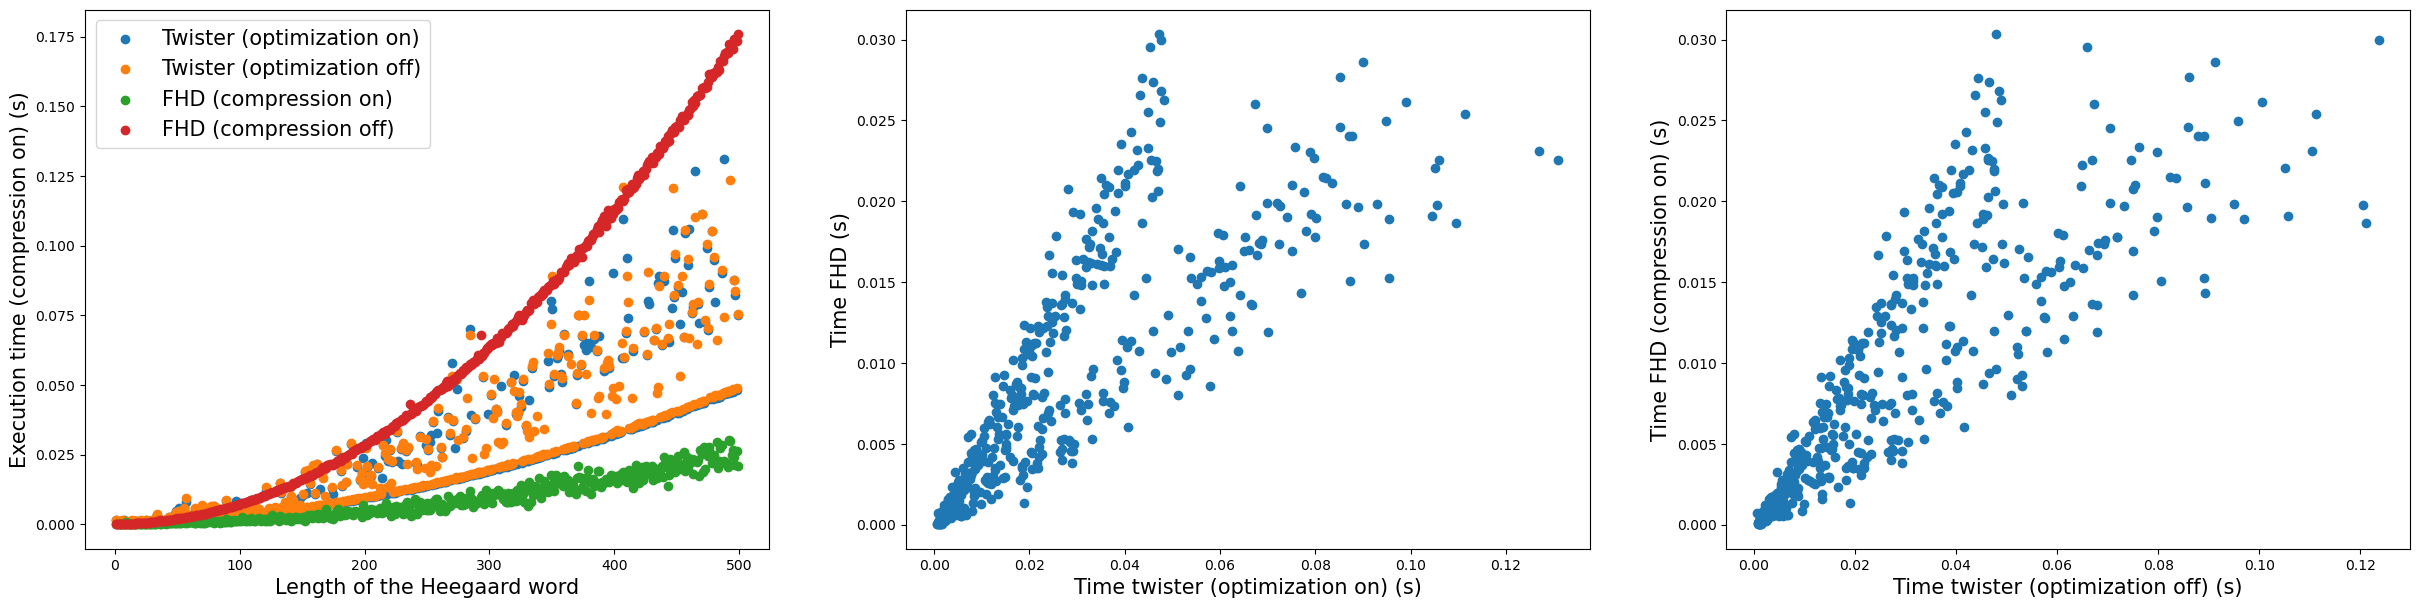

In [8]:
n_max = 500

time_twister = []
time_twister_no_optimization = []
time_fhd = []
time_fhd_no_compression = []


fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = torus.random_word(n)
    
    start = time.time()
    manifold_optimized = torus.splitting(gluing = gluing, handles= 'a*A')
    manifold_optimized.homology()
    end = time.time()
    time_twister.append(end-start)

    start = time.time()
    manifold_not_optimized = torus.splitting(gluing = gluing, handles= 'a*A', optimize = False)
    manifold_not_optimized.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)

    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = True)
    fhd_diagram.homology()
    end = time.time()
    time_fhd.append(end-start) 
    
    
    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = False)
    fhd_diagram.homology()
    end = time.time()
    time_fhd_no_compression.append(end-start) 


fig, axs = plt.subplots(1,3, figsize = (30,7))

axs[0].scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
axs[0].scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
axs[0].scatter(range(1,n_max), time_fhd, label = 'FHD (compression on)')
axs[0].scatter(range(1,n_max), time_fhd_no_compression, label = 'FHD (compression off)')
axs[0].legend(fontsize = 15)
axs[0].set_xlabel('Length of the Heegaard word', fontsize = 15)
axs[0].set_ylabel('Execution time (compression on) (s)', fontsize = 15)

axs[1].scatter(time_twister, time_fhd)
axs[1].set_xlabel( 'Time twister (optimization on) (s)', fontsize = 15)
axs[1].set_ylabel('Time FHD (s)', fontsize = 15)

axs[2].scatter(time_twister_no_optimization, time_fhd)
axs[2].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[2].set_ylabel('Time FHD (compression on) (s)', fontsize = 15)

plt.savefig('Images/random_genus_1.pdf')
plt.show()

Notice that we are still often faster than snappy's twister. This happens because the mapping class group of the torus has only 2 generators, so compressions are often possible. We note that while twister is implemented in C++, FHD's implementations uses only Python.

## Genus 2

We now explore the case of genus 2. Here, our only tool is FHDLong, the cellular structure assumed is 

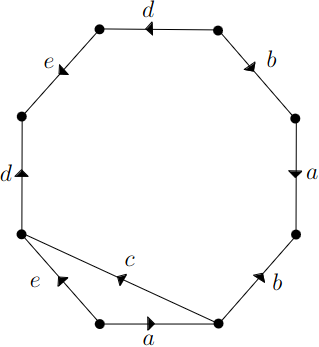

In [9]:
double_torus = snappy.twister.Surface('S_2')

# Cellular structure of the double torus, see the diagram above.
alpha_curves_standard = {'a': SLP(['b']), 'e': SLP(['d*'])}
alpha_curves_edges = {'a':['a'], 'e':['e']}
generators_standard = {'a': SLP(['b*']), 'b': SLP(['c*','a','#0.#1']), 'c': SLP(['b','d','#0.#1']),'d': SLP(['c*','e*','#0.#1']), 'e': SLP(['d'])}
generators_edge = {'a':['a'], 'b':['b'], 'c':['c'], 'd':['d'], 'e':['e']}

gluing = double_torus.random_word(10)

print('Gluing: ', gluing)

manifold_optimized = double_torus.splitting(gluing = gluing, handles= 'a*e*A*E')

manifold_not_optimized = double_torus.splitting(gluing = gluing, handles= 'a*e*A*E', optimize = False)

fhd_compressed = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
fhd_compressed.dehn_twist(gluing, compress = True)

fhd_not_compressed = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)
fhd_not_compressed.dehn_twist(gluing) 

print('Homology of snappy (optimization on):', manifold_optimized.homology())
print('Homology of snappy (optimization off):', manifold_not_optimized.homology())
print('FHD (compression on):', fhd_compressed.homology())
print('FHD (compression off):', fhd_not_compressed.homology())

Gluing:  AAECedeDcb
Homology of snappy (optimization on): 0
Homology of snappy (optimization off): 0
FHD (compression on): 0
FHD (compression off): 0


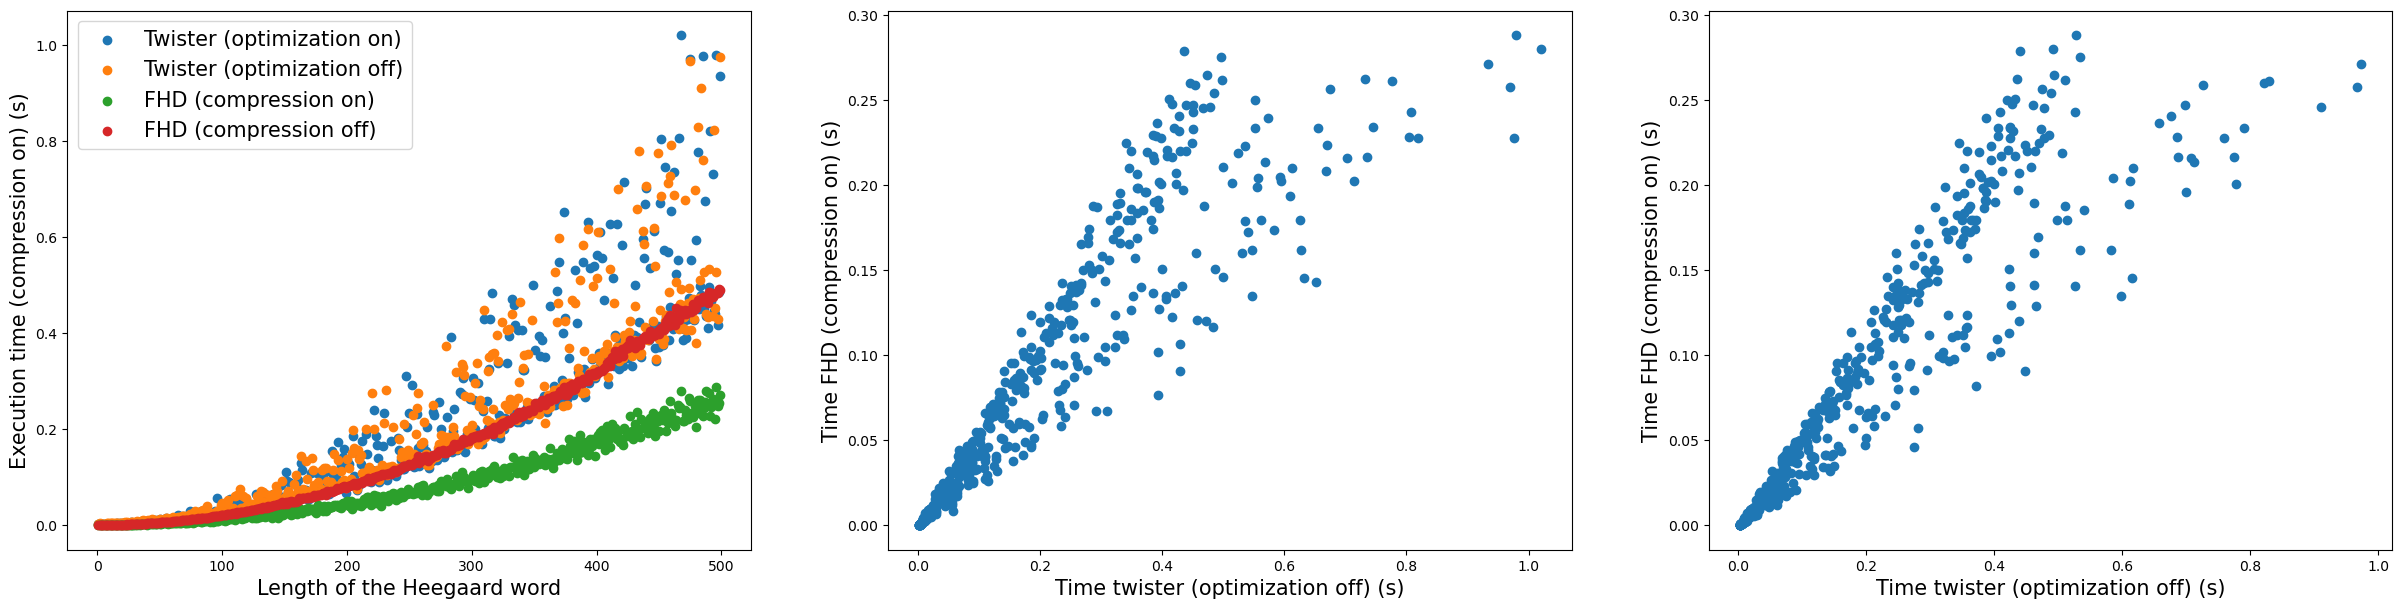

In [10]:
n_max = 500

time_twister = []
time_twister_no_optimization = []
time_fhd = []
time_fhd_no_compression = []


fhd_diagram = FHD.FHDLong(alpha_curves_standard, alpha_curves_edges, generators_standard, generators_edge)

for n in range(1,n_max):
    gluing = double_torus.random_word(n)
    
    start = time.time()
    manifold_optimized = double_torus.splitting(gluing = gluing, handles= 'a*e*A*E')
    manifold_optimized.homology()
    end = time.time()
    time_twister.append(end-start)

    start = time.time()
    manifold_not_optimized = double_torus.splitting(gluing = gluing, handles= 'a*e*A*E', optimize = False)
    manifold_not_optimized.homology()
    end = time.time()
    time_twister_no_optimization.append(end-start)

    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = True)
    fhd_diagram.homology()
    end = time.time()
    time_fhd.append(end-start) 
    
    
    start = time.time()
    fhd_diagram.reset()
    fhd_diagram.dehn_twist(gluing, compress = False)
    fhd_diagram.homology()
    end = time.time()
    time_fhd_no_compression.append(end-start) 
    


fig, axs = plt.subplots(1,3, figsize = (30,7))

axs[0].scatter(range(1,n_max), time_twister, label = 'Twister (optimization on)')
axs[0].scatter(range(1,n_max), time_twister_no_optimization, label = 'Twister (optimization off)')
axs[0].scatter(range(1,n_max), time_fhd, label = 'FHD (compression on)')
axs[0].scatter(range(1,n_max), time_fhd_no_compression, label = 'FHD (compression off)')
axs[0].legend(fontsize = 15)
axs[0].set_xlabel('Length of the Heegaard word', fontsize = 15)
axs[0].set_ylabel('Execution time (compression on) (s)', fontsize = 15)

axs[1].scatter(time_twister, time_fhd)
axs[1].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[1].set_ylabel('Time FHD (compression on) (s)', fontsize = 15)

axs[2].scatter(time_twister_no_optimization, time_fhd)
axs[2].set_xlabel( 'Time twister (optimization off) (s)', fontsize = 15)
axs[2].set_ylabel('Time FHD (compression on) (s)', fontsize = 15)

plt.savefig('Images/random_genus_2.pdf')
plt.show()